# Setup


In [ ]:
!python3 -m spacy download es_core_news_md
!pip install es-lemmatizer
!pip install unidecode
!pip install pyLDAvis
!pip install --upgrade pandas
!pip install git+https://github.com/rwalk/gsdmm.git

2022-08-03 20:23:29.637687: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.3 MB 928 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.2 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend de

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import datetime
import spacy
import io
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.manifold
from collections import Counter
from unidecode import unidecode
from es_lemmatizer import lemmatize as lmtz
%matplotlib inline

@spacy.Language.component("lemmatize")
def lemmatize(doc):
  return lmtz(doc)

nlp = spacy.load("es_core_news_md")
nlp.remove_pipe("lemmatizer")
nlp.add_pipe("lemmatize", before="ner")

<function __main__.lemmatize>

# Parseo

In [ ]:
#Parseo del msg
def is_msg(string):
  msg = bool(re.match(r"\d{1,2}/\d{1,2}/\d{4} \d{2}:\d{2} - .*: .*", string))
  multimedia = "<Multimedia omitido>" in string
  deleted = "Este mensaje fue eliminado" in string
  return msg and not multimedia and not deleted

def get_msg_day(string):
  res = re.search(r"\d{1,2}/\d{1,2}/\d{4}", string)
  str_date = string[res.start() : res.end()]
  date = datetime.datetime.strptime(str_date, "%d/%m/%Y").date()
  day = date.strftime("%A")
  return day

def get_msg_hour_vector(string):
  res = re.search(r"\d{2}:\d{2}", string)
  str_date = string[res.start() : res.end()]
  time = datetime.datetime.strptime(str_date, "%H:%M").time()
  minutes = time.hour * 60 + time.minute
  vector_angle = minutes * math.pi / 720
  x = math.cos(vector_angle) + 1
  y = math.sin(vector_angle) + 1

  return (round(x, 3), round(y, 3))

def get_msg_author(string):
  res = re.search(r" - .*:", string)
  author = string[res.start()+3 : res.end()-1]
  return author

def get_msg_content(string):
  res = re.search(r"\d{1,2}/\d{1,2}/\d{4} \d{2}:\d{2} - .*: ", string)
  content = string[res.end():]
  return content

In [ ]:
from math import atan2, pi
def time_distance(v1, v2):
  v1_raw_angle = atan2(v1[1], v1[0])*180/pi 
  v1_angle = v1_raw_angle if v1_raw_angle>=0 else 180 + (180 + v1_raw_angle)

  v2_raw_angle = atan2(v2[1], v2[0])*180/pi 
  v2_angle = v2_raw_angle if v2_raw_angle>=0 else 180 + (180 + v2_raw_angle)

  distance = v2_angle - v1_angle

  return distance/15

In [ ]:
raw_msgs = list()
with open("./drive/MyDrive/chat.txt", "r") as file:
    for line in file:
        if is_msg(line):
          raw_msgs.append(line.rstrip('\n'))
"""
with open("./drive/MyDrive/chatbasquet.txt", "r") as file:
    for line in file:
        if is_msg(line):
          raw_msgs.append(line.rstrip('\n'))
"""

'\nwith open("./drive/MyDrive/chatbasquet.txt", "r") as file:\n    for line in file:\n        if is_msg(line):\n          raw_msgs.append(line.rstrip(\'\n\'))\n'

In [ ]:
msgs_dicts = list()
for msg in raw_msgs:
  new_msg_dict = {
      'author': get_msg_author(msg),
      'text': get_msg_content(msg),
      'time': get_msg_hour_vector(msg),
      'day': get_msg_day(msg),
  }

  if msgs_dicts and time_distance(msgs_dicts[-1]['time'], new_msg_dict['time']) < 0.1 and msgs_dicts[-1]['author'] == new_msg_dict['author']:
    msgs_dicts[-1]['text'] = msgs_dicts[-1]['text'] + ', ' + new_msg_dict['text'] 
  else:
    msgs_dicts.append(new_msg_dict)

# Processing

In [ ]:
from spacy.tokens import Token

whitelist = ['ojo', 'jjoo', 'cmj', 'eje']
def is_laugh(token):
  text = token.text
  n = text.lower().count('j')
  return n >= len(text)/3 and text.lower() not in whitelist

Token.set_extension("is_laugh", getter=is_laugh, force=True)

In [ ]:
custom_stop_words = 'ahhh ok ta eu pq vos ah uh re ahh ey eyy eh ehh ehhh ahre osea bolo asique sisi xd xdd xddd xdddd culiao chabon man bro mal culiau tipo nero onda'.split(" ")
stop_words = custom_stop_words + [
'a','actualmente','adelante','además','afirmó','agregó','ahora','ahí','al','algo','alguna','algunas','alguno','algunos','algún','alrededor','ambos','ampleamos','ante','anterior','antes','apenas',
'aproximadamente','aquel','aquellas','aquellos','aqui','aquí','arriba','aseguró','así','atras','aunque','ayer','añadió','aún','bajo','bastante','bien','buen','buena','buenas','bueno','buenos','cada','casi','cerca','cierta','ciertas','cierto','ciertos','cinco','comentó','como','con','conocer','conseguimos','conseguir','considera','consideró','consigo','consigue','consiguen','consigues','contra','cosas','creo','cual','cuales','cualquier','cuando','cuanto','cuatro','cuenta','cómo','da','dado', 'dale', 'dan','dar','de','debe','deben','debido','decir','dejó','del','demás','dentro','desde','después','dice','dicen','dicho','dieron','diferente','diferentes','dijeron','dijo','dio','donde','dos','durante','e','ejemplo','el','ella','ellas','ello','ellos','embargo','empleais','emplean','emplear','empleas','empleo','en','encima','encuentra','entonces','entre','era','erais','eramos','eran','eras','eres','es','esa','esas','ese','eso','esos','esta','estaba','estabais','estaban','estabas','estad','estada','estadas','estado','estados','estais','estamos','estan','estando','estar','estaremos','estará','estarán','estarás','estaré','estaréis','estaría','estaríais','estaríamos','estarían','estarías','estas','este','estemos','esto','estos','estoy','estuve','estuviera','estuvierais','estuvieran','estuvieras','estuvieron','estuviese','estuvieseis','estuviesen','estuvieses','estuvimos','estuviste','estuvisteis','estuviéramos','estuviésemos','estuvo','está','estábamos','estáis','están','estás','esté','estéis','estén','estés','ex','existe','existen','explicó','expresó','fin','fue','fuera','fuerais','fueran','fueras','fueron','fuese','fueseis','fuesen','fueses','fui','fuimos','fuiste','fuisteis','fuéramos','fuésemos','gran','grandes','gueno','ha',
'haber','habida','habidas','habido','habidos','habiendo','habremos','habrá','habrán','habrás','habré','habréis','habría','habríais','habríamos','habrían','habrías','habéis','había','habíais','habíamos','habían','habías','hace','haceis','hacemos','hacen','hacer','hacerlo','haces','hacia','haciendo','hago','han','has','hasta','hay','haya','hayamos','hayan','hayas','hayáis','he','hecho','hemos','hicieron','hizo','hoy','hube','hubiera','hubierais','hubieran','hubieras','hubieron','hubiese','hubieseis','hubiesen','hubieses','hubimos','hubiste','hubisteis','hubiéramos','hubiésemos','hubo','igual','incluso','indicó','informó','intenta','intentais','intentamos','intentan','intentar','intentas','intento','ir','junto','la','lado','largo','las','le','les','llegó','lleva','llevar','lo','los','luego','lugar','manera','manifestó','mayor','me','mediante','mejor','mencionó','menos','mi','mientras','mio','mis','misma','mismas','mismo','mismos','modo','momento','mucha','muchas','mucho','muchos','muy','más','mí','mía','mías','mío','míos','nada','nadie','ni','ninguna','ningunas','ninguno','ningunos','ningún','no','nos','nosotras','nosotros','nuestra','nuestras','nuestro','nuestros','nueva','nuevas','nuevo','nuevos','nunca','o','ocho','os','otra','otras','otro','otros','para','parece','parte','partir','pasada','pasado','pero','pesar','poca','pocas','poco','pocos','podeis','podemos','poder','podria','podriais','podriamos','podrian','podrias','podrá','podrán','podría','podrían','poner','por','por qué','porque','posible','primer','primera','primero','primeros','principalmente','propia','propias','propio','propios','próximo','próximos','pudo','pueda','puede','pueden','puedo','pues','que','quedó','queremos','quien','quienes','quiere','quién','qué','realizado','realizar','realizó','respecto','sabe','sabeis','sabemos','saben','saber','sabes','se','sea','seamos','sean','seas','segunda','segundo','según','seis','ser','seremos','será','serán','serás','seré','seréis','sería','seríais','seríamos','serían','serías','seáis','señaló','si','sido','siempre','siendo','siete','sigue','siguiente','sin','sino','sobre','sois','sola','solamente','solas','solo','solos','somos','son','soy','su','sus','suya','suyas','suyo','suyos','sí','sólo','tal','también','tampoco','tan','tanto','te','tendremos','tendrá','tendrán','tendrás','tendré','tendréis','tendría','tendríais','tendríamos','tendrían','tendrías','tened','teneis','tenemos','tener','tenga','tengamos','tengan','tengas','tengo','tengáis','tenida','tenidas','tenido','tenidos','teniendo','tenéis','tenía','teníais','teníamos','tenían','tenías','tercera','ti','tiempo','tiene','tienen','tienes','toda','todas','todavía','todo','todos','total','trabaja','trabajais','trabajamos','trabajan','trabajar','trabajas','trabajo','tras','trata','través','tres','tu','tus','tuve','tuviera','tuvierais','tuvieran','tuvieras','tuvieron','tuviese','tuvieseis','tuviesen','tuvieses','tuvimos','tuviste','tuvisteis','tuviéramos','tuviésemos','tuvo','tuya','tuyas','tuyo','tuyos','tú','ultimo','un','una','unas','uno','unos','usa','usais','usamos','usan','usar','usas','uso','usted','va','vais','valor','vamos','van','varias','varios','vaya','veces','ver','verdad','verdadera','verdadero','vez','vosotras','vosotros','voy','vuestra','vuestras','vuestro','vuestros','y','ya','yo','él','éramos','ésta','éstas','éste','éstos','última','últimas','último','últimos']
stop_words = [unidecode(w.lower()) for w in stop_words]

def is_valid(token):
  return not token._.is_laugh and len(token) > 2 and token.is_alpha and unidecode(token.text) not in stop_words

In [ ]:
from spacy.tokens import Doc

def pre_process_token(token):
  if token._.is_laugh:
    return 'jaja'
  else:
    return unidecode(token.text.lower())

def lower_and_unidecode(doc):
    text = ''
    words = [pre_process_token(token) for token in doc]
    return list(filter(lambda s: s != '', words))

@spacy.Language.component("pre_process_text")
def pre_process_text(doc):
    new_words = lower_and_unidecode(doc)
    new_doc = Doc(doc.vocab, words=new_words)
    return new_doc
  
nlp.add_pipe("pre_process_text", first=True)

<function __main__.pre_process_text>

In [ ]:
def proc_doc(doc):
  words = [unidecode(token.text) for token in doc if is_valid(token)]
  return words

In [ ]:
def process_messages(msg_dict_list):
  current_msg = 0
  full_texts = []
  messages = []
  texts = [msg['text'] for msg in msg_dict_list]
  for doc in nlp.pipe(texts):
    if len(doc) < 1:
      continue

    full_texts.append(doc.text)
    msg_words = proc_doc(doc)
    messages.append(msg_words)

  return full_texts, messages

In [ ]:
full_texts, messages = process_messages(msgs_dicts)

# LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
import gensim

In [ ]:
dictionary = gensim.corpora.Dictionary(messages)
dictionary.filter_extremes(no_below=30, no_above=0.1)
bow_corpus = [dictionary.doc2bow(doc) for doc in messages]

In [ ]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 8,
                                   id2word = dictionary,                                    
                                   passes = 40,
                                   workers = 4)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))
    print("\n")

Topic: 0 
Words: 0.094*"comer" + 0.070*"sileo" + 0.049*"viejo" + 0.043*"jugar" + 0.040*"queres" + 0.037*"foto" + 0.037*"auto" + 0.032*"ustedes" + 0.032*"positivo" + 0.026*"joda"


Topic: 1 
Words: 0.071*"chona" + 0.053*"joya" + 0.048*"vas" + 0.038*"mira" + 0.036*"quiero" + 0.036*"narido" + 0.035*"anda" + 0.031*"pasa" + 0.031*"plata" + 0.029*"grupo"


Topic: 2 
Words: 0.057*"seguro" + 0.056*"tarde" + 0.045*"ganas" + 0.038*"posta" + 0.037*"deja" + 0.037*"yendo" + 0.036*"idea" + 0.032*"dije" + 0.031*"sabado" + 0.030*"abuso"


Topic: 3 
Words: 0.102*"che" + 0.100*"sarquis" + 0.052*"final" + 0.051*"falta" + 0.051*"ivan" + 0.043*"anos" + 0.041*"fernet" + 0.041*"podes" + 0.040*"tomar" + 0.035*"domingo"


Topic: 4 
Words: 0.090*"capaz" + 0.085*"hora" + 0.052*"michel" + 0.047*"alguien" + 0.045*"nico" + 0.044*"verga" + 0.036*"rato" + 0.035*"salgo" + 0.032*"salir" + 0.030*"viernes"


Topic: 5 
Words: 0.128*"aca" + 0.084*"noche" + 0.050*"nomas" + 0.039*"quieren" + 0.038*"gente" + 0.036*"sale" + 0.

In [ ]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.019878  0.289240       1        1  13.641146
5      0.193483  0.231883       2        1  13.105980
7      0.128958 -0.079170       3        1  12.982447
2     -0.064542 -0.178389       4        1  12.469060
4      0.193663 -0.127447       5        1  12.338255
6     -0.242765  0.106618       6        1  12.179337
0      0.094240 -0.155242       7        1  12.162091
3     -0.283159 -0.087495       8        1  11.121685, topic_info=        Term        Freq       Total Category  logprob  loglift
129      aca  388.000000  388.000000  Default  30.0000  30.0000
0       casa  331.000000  331.000000  Default  29.0000  29.0000
12    manana  413.000000  413.000000  Default  28.0000  28.0000
25       che  260.000000  260.000000  Default  27.0000  27.0000
17   sarquis  256.000000  256.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
170    meses   18.228416   28.482638   Topic8  -4.9456   1.7500
145   sabado   41.708047  131.947429   Topic8  -4.1178   1.0446
187     vino   11.652526   45.569643   Topic8  -5.3930   0.8326
12    manana   82.803130  413.984194   Topic8  -3.4321   0.5869
199    finde   26.356058  115.666232   Topic8  -4.5768   0.7173

[301 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
239       4  0.993156    abuso
129       2  0.997067      aca
24        2  0.979409  acuerdo
200       2  0.994739   afuera
76        5  0.995302  alguien
...     ...       ...      ...
5         7  0.990272   vieron
187       3  0.724166     vino
187       8  0.263333     vino
188       7  0.983594   vuelta
162       4  0.988923    yendo

[309 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 8, 3, 5, 7, 1, 4])

---

# GSDMM


Gibbs Sampling Dirichlet Mixture Model


In [ ]:
from gsdmm import MovieGroupProcess
import gensim
import nltk
from nltk.stem.snowball import SnowballStemmer

In [ ]:
K=8
gsdmm = MovieGroupProcess(K=K, alpha=1/K, beta=1/K, n_iters=30)

# fit GSDMM model
df = pd.DataFrame({'messages': messages})
docs = df.messages.to_numpy()
y = gsdmm.fit(docs, len(dictionary))

In stage 0: transferred 15676 clusters with 8 clusters populated
In stage 1: transferred 12545 clusters with 8 clusters populated
In stage 2: transferred 11510 clusters with 8 clusters populated
In stage 3: transferred 10939 clusters with 8 clusters populated
In stage 4: transferred 10688 clusters with 8 clusters populated
In stage 5: transferred 10465 clusters with 8 clusters populated
In stage 6: transferred 10341 clusters with 8 clusters populated
In stage 7: transferred 10179 clusters with 8 clusters populated
In stage 8: transferred 10148 clusters with 8 clusters populated
In stage 9: transferred 10158 clusters with 8 clusters populated
In stage 10: transferred 10097 clusters with 8 clusters populated
In stage 11: transferred 9973 clusters with 8 clusters populated
In stage 12: transferred 9956 clusters with 8 clusters populated
In stage 13: transferred 9901 clusters with 8 clusters populated
In stage 14: transferred 9825 clusters with 8 clusters populated
In stage 15: transferred

In [ ]:
from wordcloud import WordCloud
def cluster_cloud(model, cluster_label):
  # Get topic word distributions from gsdmm model
  cluster_word_distribution = gsdmm.cluster_word_distribution

  # Select topic you want to output as dictionary (using topic_number)
  topic_dict = cluster_word_distribution[cluster_label]

  # Generate a word cloud image
  wordcloud = WordCloud(background_color='#fcf2ed', 
                              width=1800,
                              height=700,
                              colormap='RdBu').generate_from_frequencies(topic_dict)

  # Print to screen
  fig, ax = plt.subplots(figsize=[20,10])
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off");

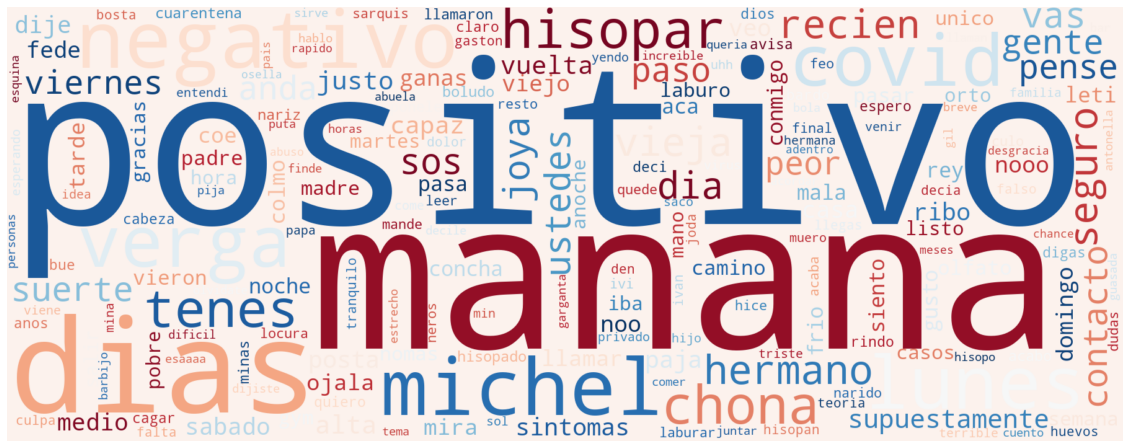

In [ ]:
cluster_cloud(gsdmm, 1)

In [ ]:
import pickle
with open("v3.model", "wb") as f:
 pickle.dump(gsdmm, f)
 f.close()

In [ ]:
# print number of documents per topic
doc_count = np.array(gsdmm.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-20:][::-1]
print('Most important clusters (by number of docs inside):', top_index)

# define function to get top words per topic
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts = sorted(cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster, sort_dicts))

# get top words in topics
top_words(gsdmm.cluster_word_distribution, top_index, 20)

Number of documents per topic : [3623 2352 2530 2124 1772 2065 2451 2331]
Most important clusters (by number of docs inside): [0 2 6 1 7 3 5 4]

Cluster 0 : [('manana', 183), ('aca', 181), ('noche', 165), ('comer', 137), ('hora', 135), ('casa', 132), ('tarde', 115), ('capaz', 110), ('pinta', 83), ('quieren', 82), ('che', 75), ('tomar', 73), ('rato', 69), ('nomas', 68), ('vengan', 62), ('venir', 62), ('yendo', 61), ('joya', 58), ('juntamos', 56), ('breve', 56)]

Cluster 2 : [('ribo', 90), ('michel', 78), ('sarquis', 76), ('sileo', 67), ('ivan', 63), ('nico', 62), ('chona', 60), ('aca', 55), ('gracias', 51), ('narido', 43), ('vas', 43), ('comer', 41), ('casa', 40), ('dia', 39), ('manana', 38), ('paso', 34), ('grupo', 30), ('turno', 30), ('noche', 29), ('nomas', 28)]

Cluster 6 : [('pasa', 50), ('ribo', 46), ('claro', 46), ('auto', 44), ('sileo', 39), ('internet', 38), ('mira', 36), ('joya', 35), ('foto', 35), ('anda', 35), ('michel', 34), ('verga', 34), ('tenes', 32), ('loco', 27), ('tre

# Classification


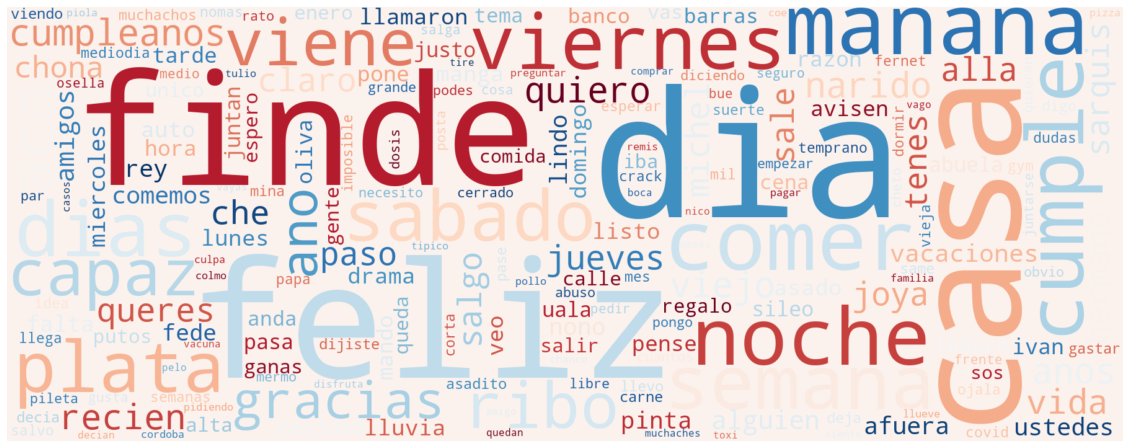

In [ ]:
cluster_cloud(gsdmm, 7)

In [ ]:
label_topic_dict = {
    0: 'Juntarse',
    1: 'Covid',
    2: 'Gente',
    3: 'Undefined',
    4: 'Juntarse',
    5: 'Futbol',
    6: 'Undefined',
    7: 'Salida',
}

In [ ]:
joined = [" ".join(m) for m in messages]
tagged = list()
for i in range(len(messages)):
  label, score = gsdmm.choose_best_label(messages[i])
  tagged.append((joined[i], label_topic_dict[label]))

In [ ]:
from gensim.models import KeyedVectors
file_path = f"drive/MyDrive/fasttext_spanish_twitter_100d.vec"
vectorizer = KeyedVectors.load_word2vec_format(file_path)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
tagged_vectors = list()
idx = 0
for doc in nlp.pipe(full_texts):
  result_vector = np.ones(100)
  for token in doc:
    try:
      result_vector += vectorizer.word_vec(token.text)
    except KeyError:
      pass

  tag = tagged[idx][1]
  tagged_vectors.append((result_vector, tag))
  idx += 1

In [ ]:
tagged_vectors = list()
idx = 0
for m in messages:
  result_vector = np.zeros(100)
  for word in m:
    try:
      result_vector += vectorizer.word_vec(word)
    except KeyError:
      pass

  tag = tagged[idx][1]
  tagged_vectors.append((result_vector, tag))
  idx += 1

In [ ]:
vectors = [t[0] for t in tagged_vectors]
tags = [t[1] for t in tagged_vectors]

vector_df = pd.DataFrame(data=vectors)
tag_df = pd.DataFrame(data=tags)

In [ ]:
vector_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.522600,-0.504722,0.935760,-0.208469,0.106975,0.576940,-0.662347,-0.577718,-1.507000,-1.222380,...,0.102822,-0.630840,-0.560420,-0.535970,-0.223530,0.353665,0.288870,0.211599,-0.043814,-0.433713
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-1.398908,-0.662238,3.421780,2.788520,-0.509013,1.520384,-4.012174,-2.812085,-4.995980,-3.437883,...,1.557104,-0.155465,-3.368901,-0.487317,-0.558790,-0.689366,2.009049,0.374490,3.203430,0.569404
3,0.564734,-0.451840,0.208740,0.137841,-0.665590,0.091660,-0.588200,-0.729820,-0.689710,-0.616250,...,0.201350,-0.652680,-1.078510,0.915100,-0.176750,0.082596,0.113310,0.283690,1.931450,0.048750
4,-0.585040,0.031350,0.500401,0.885251,-0.297465,-0.003432,-1.334032,-1.287936,-2.115950,-0.540391,...,1.393770,-0.811025,-0.428658,0.896284,-1.415552,1.810180,0.616780,0.191500,0.103585,-0.019710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19243,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19244,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19245,-1.110890,-0.331664,1.007351,-0.460475,0.233322,0.382965,-0.879044,-0.882674,-1.232072,-1.610699,...,1.247760,-0.308708,-0.462694,-0.800090,-0.445472,0.686539,0.956999,-0.281530,0.469014,0.554946
19246,-1.397405,-0.075163,0.384587,0.063080,0.367640,0.430080,-0.321803,-0.240510,-0.815860,-1.322968,...,0.798740,-0.675193,-1.487610,0.051491,-0.280967,0.263350,0.513010,-0.545240,0.346290,-0.083824


In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(vector_df, tag_df[0])

XGBClassifier(objective='multi:softprob')

In [ ]:
def vectorize_msg(msg):
  doc = nlp(msg)
  result_vector = np.zeros(100)
  for token in doc:
    try:
      result_vector += vectorizer.word_vec(token.text)
    except KeyError:
      pass
  return result_vector

def msg_predict(msg, classifier):
  vector = vectorize_msg(msg)
  tag = classifier.predict([vector])
  return tag

In [ ]:
def vectorize_msg(words):
  result_vector = np.zeros(100)
  for token in words:
    try:
      result_vector += vectorizer.word_vec(token)
    except KeyError:
      pass
  return result_vector

def msg_predict(msg, classifier):
  doc = nlp(msg)
  words = proc_doc(doc)
  vector = vectorize_msg(words)
  tag = classifier.predict(pd.DataFrame(vector).T)
  return tag

In [ ]:
m = """me dio positivo el hisopado, adentro 15 dias """
print("Prediccion: ", msg_predict(m, model)[0])

Prediccion:  Covid


In [ ]:
m = """Eu ya compramos para las sangrías, alguien compre el hielo"""
print("Prediccion: ", msg_predict(m, model)[0])

Prediccion:  Juntarse


In [ ]:
m = """Estoy sentado en un crater desierto, sigo esperando el temblor"""
print("Prediccion: ", msg_predict(m, model)[0])

Prediccion:  Juntarse


In [ ]:
m = """Que bien juega messi"""
print("Prediccion: ", msg_predict(m, model)[0])

Prediccion:  Futbol


In [ ]:
m = """Será lo tembloroso de la espuma bailando en mi corazón rabioso"""
print("Prediccion: ", msg_predict(m, model)[0])

Prediccion:  Juntarse
